In [1]:
# Install Libraries
!pip install --quiet --upgrade yfinance
!pip install --quiet torch-geometric
!pip install --quiet torch torchvision
!pip install --quiet optuna-integration
!pip install --quiet pytorch-ranger
!pip install --quiet torch_optimizer
!pip install --quiet transformers
!pip install --quiet bitsandbytes accelerate 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency re

In [2]:
# Import Essentials
import os
import json
import joblib
import warnings
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter


warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
# Deep Learning
import torch
import optuna
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import AutoModel, AutoConfig
import torch_optimizer as optim
from torch.amp import GradScaler, autocast  # Updated import location
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            precision_recall_curve, roc_curve)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## **Functions**

In [4]:
# Technical ndicators

def calculate_sma(df, window):
    return df['Close'].rolling(window=window).mean()

def calculate_ema(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def calculate_macd(df):
    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=9, adjust=False).mean()
    return macd, signal

def calculate_rsi(df):
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_bollinger_bands(df):
    middle_bb = df['Close'].rolling(window=20).mean()
    upper_bb = middle_bb + 2 * df['Close'].rolling(window=20).std()
    lower_bb = middle_bb - 2 * df['Close'].rolling(window=20).std()
    return middle_bb, upper_bb, lower_bb

def calculate_stochastic_oscillator(df):
    lowest_low = df['Low'].rolling(window=14).min()
    highest_high = df['High'].rolling(window=14).max()
    slowk = ((df['Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    slowd = slowk.rolling(window=3).mean()
    return slowk, slowd

def calculate_cmf(df, window=20):
    mfv = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low']) * df['Volume']
    cmf = mfv.rolling(window=window).sum() / df['Volume'].rolling(window=window).sum()
    return cmf

def calculate_cci(df, window=20):
    """Calculate Commodity Channel Index (CCI)."""
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma = typical_price.rolling(window=window).mean()
    mean_deviation = (typical_price - sma).abs().rolling(window=window).mean()
    cci = (typical_price - sma) / (0.015 * mean_deviation)
    return cci

# Function to generate trading signals
def generate_trading_signals(df):
    # df['SMA_30'] = calculate_sma(df, 30)
    # df['SMA_100'] = calculate_sma(df, 100)
    df['EMA_12'] = calculate_ema(df, 12)
    df['EMA_26'] = calculate_ema(df, 26)
    df['RSI'] = calculate_rsi(df)
    df['MiddleBB'], df['UpperBB'], df['LowerBB'] = calculate_bollinger_bands(df)
    df['SlowK'], df['SlowD'] = calculate_stochastic_oscillator(df)
    df['CMF'] = calculate_cmf(df)
    df['CCI'] = calculate_cci(df)
    macd, signal = calculate_macd(df)
    df['MACD'] = macd
    df['MACD_Signal_Line'] = signal
    return df


In [5]:
# Download stock data
def download_ticker(ticker, start_date, end_date):
    """Download and clean stock data from Yahoo Finance"""
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # Clean column names
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    # Remove unnecessary columns
    df = df.drop('Adj Close', axis=1, errors='ignore')
    
    return df


In [6]:
# Macroeconomic analysis
class MacroEconomicAnalyzer:
    def __init__(self):
        self.tickers = {
            # Interest Rates
            '2Y_Yield': '^FVX',
            '10Y_Yield': '^TNX',
            
            # Equities
            'SP500': '^GSPC',
            'Nasdaq': '^IXIC',
            
            # Commodities
            'Gold': 'GC=F',
            'Oil': 'CL=F',
            'Copper': 'HG=F',
            
            # Credit
            'High_Yield': 'HYG',
            'Investment_Grade': 'LQD',
            
            # Volatility
            'VIX': '^VIX',
            
            # International Markets
            'Europe': 'FEZ',
            'China': 'FXI',
            'Japan': 'EWJ'
        }
        
        self.classification_meaning = {
            # Interest Rate Classifications
            "Low": "Favorable for growth stocks, accommodative policy",
            "Neutral": "Neither stimulative nor restrictive",
            "High": "Restrictive monetary policy",
            
            # Growth Classifications
            "Positive": "Economy expanding, earnings growing",
            "Negative": "Economy contracting",
            
            # Inflation Classifications  
            "Low": "Prices stable",
            "Moderate": "Within target range",
            "High": "Rapid price increases",
            
            # Market Sentiment
            "Complacent": "Investors optimistic",
            "Neutral": "Balanced risk appetite",
            "Fearful": "Investors panicking",
            
            # Recession Risk
            "High": "Recession likely",
            "Low": "Economy healthy",
            
            # Yield Curve
            "Normal": "10Y > 2Y, healthy economy",
            "Flat": "10Y ≈ 2Y, uncertainty",
            "Inverted": "10Y < 2Y, recession warning"
        }
    
    def download_data(self, start_date='2022-01-01', end_date='2026-01-01'):
        """Download all market data from Yahoo Finance"""
        if end_date is None:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        try:
            # Download data in a single request
            data = yf.download(
                list(self.tickers.values()),
                start=start_date,
                end=end_date,
                progress=False,
                group_by='column'
            )['Close']
            
            
            # Rename columns to our feature names
            data = data.rename(columns={v:k for k,v in self.tickers.items()})
            return data.dropna()
        except Exception as e:
            print(f"Error downloading data: {e}")
            return pd.DataFrame()

    def calculate_features(self, data):
        """Calculate all derived macroeconomic features"""
        df = data.copy()
        
        # 1. Yield Curve Analysis
        df['Yield_Spread'] = df['10Y_Yield'] - df['2Y_Yield']
        df['Yield_Inverted'] = (df['Yield_Spread'] < 0).astype(int)
        
        # Yield Curve Regime
        conditions = [
            df['Yield_Spread'] < -0.5,
            (df['Yield_Spread'] >= -0.5) & (df['Yield_Spread'] < 0),
            (df['Yield_Spread'] >= 0) & (df['Yield_Spread'] < 0.5),
            df['Yield_Spread'] >= 0.5
        ]
        choices = ['Strong Inversion', 'Mild Inversion', 'Flat', 'Normal']
        df['Curve_Regime'] = np.select(conditions, choices, default='Normal')
        
        # 2. Growth Indicators - vectorized calculations
        periods = [63, 126, 252]  # 3M, 6M, 12M in trading days
        for period in periods:
            period_name = {63: '3M', 126: '6M', 252: '12M'}[period]
            df[f'SP500_{period_name}_Return'] = df['SP500'].pct_change(period)
        
        # 3. Inflation Measures
        # Create a more balanced commodity index with equal weights
        df['Commodity_Index'] = (
            (df['Gold'] / df['Gold'].iloc[0]) + 
            (df['Oil'] / df['Oil'].iloc[0]) + 
            (df['Copper'] / df['Copper'].iloc[0])
        ) / 3
        
        df['Commodity_3M_Return'] = df['Commodity_Index'].pct_change(63)
        df['Commodity_12M_Return'] = df['Commodity_Index'].pct_change(252)
        
        # 4. Market Sentiment
        df['VIX_Level'] = df['VIX']
        df['Credit_Spread'] = df['High_Yield'] / df['Investment_Grade']
        
        # 5. International Comparisons - vectorized calculation
        for region in ['Europe', 'China', 'Japan']:
            df[f'{region}_RelToSP500'] = df[region].pct_change(21) - df['SP500'].pct_change(21)
        
        # 6. Macro Regime Classification
        df = self._classify_regimes(df)
        
        # 7. Add explanations
        df = self._add_explanations(df)
        
        return df.dropna()
    
    def _classify_regimes(self, df):
        """Classify economic regimes"""
        # Interest Rates
        conditions = [
            df['2Y_Yield'] < 1.5, 
            (df['2Y_Yield'] >= 1.5) & (df['2Y_Yield'] <= 3.5),
            df['2Y_Yield'] > 3.5
        ]
        choices = ['Low', 'Neutral', 'High']
        df['Interest_Rates'] = np.select(conditions, choices, default='Neutral')
        
        # Growth
        conditions = [
            df['SP500_6M_Return'] < -0.05,
            (df['SP500_6M_Return'] >= -0.05) & (df['SP500_6M_Return'] <= 0.05),
            df['SP500_6M_Return'] > 0.05
        ]
        choices = ['Negative', 'Neutral', 'Positive']
        df['Growth'] = np.select(conditions, choices, default='Neutral')
        
        # Inflation
        conditions = [
            df['Commodity_12M_Return'] < 0,
            (df['Commodity_12M_Return'] >= 0) & (df['Commodity_12M_Return'] <= 0.15),
            df['Commodity_12M_Return'] > 0.15
        ]
        choices = ['Low', 'Moderate', 'High']
        df['Inflation'] = np.select(conditions, choices, default='Moderate')
        
        # Market Sentiment
        conditions = [
            df['VIX'] < 15,
            (df['VIX'] >= 15) & (df['VIX'] <= 25),
            df['VIX'] > 25
        ]
        choices = ['Complacent', 'Neutral', 'Fearful']
        df['Market_Sentiment'] = np.select(conditions, choices, default='Neutral')
        
        # Recession Risk - THIS IS THE FIX FOR THE ERROR
        conditions = [df['Yield_Inverted'] & (df['SP500_6M_Return'] < 0)]
        choices = ['High']
        df['Recession_Risk'] = np.select(conditions, choices, default='Low')
        
        return df
    
    def _add_explanations(self, df):
        """Add explanation columns"""
        explain_columns = [
            'Interest_Rates', 'Growth', 'Inflation', 
            'Market_Sentiment', 'Recession_Risk'
        ]
        
        # Handle Curve_Regime specially since it has different values
        curve_meanings = {
            'Strong Inversion': self.classification_meaning['Inverted'],
            'Mild Inversion': self.classification_meaning['Inverted'],
            'Flat': self.classification_meaning['Flat'],
            'Normal': self.classification_meaning['Normal']
        }
        
        # Add explanations efficiently
        for col in explain_columns:
            df[f'{col}_Explanation'] = df[col].map(self.classification_meaning)
        
        df['Curve_Regime_Explanation'] = df['Curve_Regime'].map(curve_meanings)
        
        return df
    
    def generate_report(self, df=None, save_path=None):
        """Generate a comprehensive report of the current macro environment"""
        if df is None:
            # If no dataframe provided, use downloaded data
            raw_data = self.download_data()
            if raw_data.empty:
                return "Failed to download data for report generation."
            df = self.calculate_features(raw_data)
        
        # Get latest data point
        latest = df.iloc[-1]
        
        # Format report
        report = f"""
        === MACROECONOMIC ANALYSIS REPORT ===
        Date: {latest.name.date()}
        
        INTEREST RATES:
        2Y Yield: {latest['2Y_Yield']:.2f}%
        10Y Yield: {latest['10Y_Yield']:.2f}%
        Yield Spread: {latest['Yield_Spread']:.2f}% ({latest['Curve_Regime']})
        
        MARKET INDICATORS:
        Growth: {latest['Growth']} ({latest['Growth_Explanation']})
        Inflation: {latest['Inflation']} ({latest['Inflation_Explanation']})
        Market Sentiment (VIX: {latest['VIX']:.2f}): {latest['Market_Sentiment']}
        
        RISK ASSESSMENT:
        Recession Risk: {latest['Recession_Risk']} ({latest['Recession_Risk_Explanation']})
        
        INTERNATIONAL MARKETS (1M relative to S&P500):
        Europe: {latest['Europe_RelToSP500']:.2%}
        China: {latest['China_RelToSP500']:.2%}
        Japan: {latest['Japan_RelToSP500']:.2%}
        """
        
        if save_path:
            with open(save_path, 'w') as f:
                f.write(report)
            print(f"Report saved to {save_path}")
            
        return report


In [7]:
# Prepare complex data
def download_complex_data(stock_ticker, start_date, end_date=None):
    """
    Download and combine stock data with macroeconomic indicators
    
    Args:
        stock_ticker (str): The stock ticker to analyze (e.g., 'AAPL')
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format (defaults to today)
    
    Returns:
        tuple: (combined_df, macro_df) where:
            - combined_df has stock data merged with macro features
            - macro_df has just the macroeconomic features
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Initialize the macroeconomic analyzer
    macro_analyzer = MacroEconomicAnalyzer()
    
    # Download stock data
    print(f"Downloading stock data for {stock_ticker}...")
    stock_df = yf.download(stock_ticker, start=start_date, end=end_date)
    
    # Clean stock data
    if isinstance(stock_df.columns, pd.MultiIndex):
        stock_df.columns = stock_df.columns.get_level_values(0)
    stock_df = stock_df.drop('Adj Close', axis=1, errors='ignore')
    
    # Download and process macroeconomic data
    print("Downloading macroeconomic data...")
    raw_macro_data = macro_analyzer.download_data(start_date, end_date)
    macro_df = macro_analyzer.calculate_features(raw_macro_data)
    
    # Merge the data
    combined_df = stock_df.merge(macro_df, left_index=True, right_index=True, how='left')
    
    # Add stock-specific features
    for period in [21, 63, 252]:  # 1M, 3M, 12M in trading days
        period_name = {21: '1M', 63: '3M', 252: '12M'}[period]
        combined_df[f'Stock_{period_name}_Return'] = combined_df['Close'].pct_change(period)
    
    # Add relative performance vs SP500
    combined_df['Stock_RelToSP500'] = combined_df['Close'].pct_change(21) - combined_df['SP500'].pct_change(21)
    
    return combined_df.dropna(), macro_df.dropna()

In [8]:
# Encode Macro Features


def encode_macro_features(df):
    """
    Prepares macroeconomic features for modeling:
    - Label encodes ordinal categorical columns
    - One-hot encodes nominal columns
    - Drops explanation columns
    - Converts boolean columns to integers
    """
    df = df.copy()
    
    # --- 1. Label Encoding (Ordinal) ---
    ordinal_cols = ['Interest_Rates', 'Growth', 'Inflation', 'Recession_Risk']
    ordinal_categories = [
        ['Low', 'Neutral', 'High'],          # Interest_Rates
        ['Negative', 'Neutral', 'Positive'], # Growth
        ['Low', 'Moderate', 'High'],         # Inflation
        ['Low', 'High']                      # Recession_Risk
    ]
    
    ordinal_encoder = OrdinalEncoder(categories=ordinal_categories)
    df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])
    
    # --- 2. One-Hot Encoding (Nominal) ---
    nominal_cols = ['Market_Sentiment', 'Curve_Regime']
    df = pd.get_dummies(df, columns=nominal_cols, drop_first=False)
    
    # --- 3. Drop explanation columns ---
    explanation_cols = [col for col in df.columns if 'Explanation' in col]
    df = df.drop(columns=explanation_cols)
    
    # --- 4. Convert booleans to integers ---
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(int)
    
    return df


In [9]:
# Check Missing Values

def check_missing_values(data):
    """
    Check for missing values in a pandas DataFrame and display the total and percentage of missing values.
    
    Parameters:
        data (pd.DataFrame): The DataFrame to check for missing values.
    
    Returns:
        pd.DataFrame: A DataFrame containing the total and percentage of missing values, sorted by total in descending order.
                      Returns None if no missing values are found.
    """
    # Check for missing values
    missing_columns = data.columns[data.isnull().any()]
    
    if missing_columns.size > 0:
        missing_values = data[missing_columns].isnull().sum()
        missing_percentage = (missing_values / len(data)) * 100

        # Combine into a single DataFrame
        missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

        # Sort by Total in descending order
        missing_data = missing_data.sort_values(by='Total', ascending=False)

        
        return missing_data
    else:
        print("\nNo Missing Values Found")
        return None

# Example usage:
# missing_data_report = check_missing_values(data)

## **Deep Learning**

In [10]:
# Split the data
def prepare_financial_data(df, features, lookback=90, train_split=0.8):
    """
    Prepare financial time-series data for a 15-day trend prediction task.

    Steps:
    - Normalize only continuous features
    - Leave categorical (ordinal + one-hot) untouched
    - Create sliding windows (lookback)
    - Return PyTorch dataloaders
    """
    df_normalized = df.copy()

    # --- Step 1: Define which features to normalize ---
    categorical_features = [
        # Ordinal categorical features (encoded via OrdinalEncoder)
        'Interest_Rates', 'Growth', 'Inflation', 'Recession_Risk',
    
        # One-hot encoded Market Sentiment
        'Market_Sentiment_Complacent',
        'Market_Sentiment_Fearful',
        'Market_Sentiment_Neutral',
    
        # One-hot encoded Curve Regime
        'Curve_Regime_Flat',
        'Curve_Regime_Mild Inversion'
    ]

    continuous_features = [f for f in features if f not in categorical_features]

    # --- Step 2: Normalize only continuous features ---
    for feature in continuous_features:
        if feature in df.columns:
            train_size = int(len(df) * train_split)
            train_data = df[feature].iloc[:train_size]

            if train_data.max() == train_data.min():
                df_normalized[feature] = 0
            else:
                min_val = train_data.min()
                max_val = train_data.max()
                df_normalized[feature] = (df[feature] - min_val) / (max_val - min_val + 1e-8)

    # --- Step 3: Handle missing values ---
    df_normalized = df_normalized.ffill().bfill().fillna(0)

    # --- Step 4: Create lookback windows and labels ---
    X, y_15day = [], []
    for i in range(lookback, len(df_normalized) - 15):
        window = df_normalized[features].iloc[i - lookback:i].values
        X.append(window)

        if 'Close' in df.columns:
            price_change = df['Close'].iloc[i + 14] > df['Close'].iloc[i - 1]
            y_15day.append(float(price_change))

    X = np.array(X)
    y_15day = np.array(y_15day)

    # --- Step 5: Train/Test split ---
    train_size = int(len(X) * train_split)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y_15day[:train_size], y_15day[train_size:]

    # --- Step 6: Convert to PyTorch tensors ---
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.FloatTensor(y_train)
    y_test = torch.FloatTensor(y_test)

    # --- Step 7: Wrap in Datasets and Loaders ---
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(
        train_dataset,
        batch_size=256,
        shuffle=True,
        pin_memory=True,
        num_workers=4,
        persistent_workers=True,
        prefetch_factor=2
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=256,
        shuffle=False,
        pin_memory=True,
        num_workers=4,
        persistent_workers=True,
        prefetch_factor=2
    )

    return train_loader, test_loader


In [11]:
# Model Architecture

# --- Improved Rotary Positional Embedding Implementation ---
class RotaryEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer("inv_freq", inv_freq)
        self.seq_len_cached = None
        self.cos_cached = None
        self.sin_cached = None

    def forward(self, seq_len, device):
        if seq_len != self.seq_len_cached:
            self.seq_len_cached = seq_len
            t = torch.arange(seq_len, device=device).type_as(self.inv_freq)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq)
            emb = torch.cat((freqs, freqs), dim=-1).to(device)
            self.cos_cached = emb.cos()
            self.sin_cached = emb.sin()
        return self.cos_cached, self.sin_cached

def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin):
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

# --- Optimized Time-Series Attention Layer ---
class TimeSeriesAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.rope = RotaryEmbedding(self.head_dim)
        
    def forward(self, x):
        B, T, C = x.shape
        device = x.device
        
        # Project queries, keys, values
        q = self.q_proj(x).reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        k = self.k_proj(x).reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        v = self.v_proj(x).reshape(B, T, self.num_heads, self.head_dim).transpose(1, 2)  # [B, H, T, D]
        
        # Apply rotary embeddings
        cos, sin = self.rope(T, device)
        q, k = apply_rotary_pos_emb(q, k, cos[:T], sin[:T])
        
        # Compute attention
        attn = (q @ k.transpose(-2, -1)) * (1.0 / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32)))
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)
        
        # Compute output
        out = (attn @ v).transpose(1, 2).reshape(B, T, C)
        return self.out_proj(out)

# --- Enhanced Financial Transformer Architecture ---
class FinancialTransformer(nn.Module):
    def __init__(self, feature_dim, num_classes=1, embed_dim=256, num_heads=8,
                 num_layers=6, dropout=0.1):
        super().__init__()
        
        # Feature embedding
        self.feature_embed = nn.Sequential(
            nn.Linear(feature_dim, embed_dim*2),
            nn.Mish(),
            nn.LayerNorm(embed_dim*2),
            nn.Dropout(dropout),
            nn.Linear(embed_dim*2, embed_dim),
            nn.Mish(),
            nn.LayerNorm(embed_dim)
        )
        
        # Multi-scale processing - FIXED VERSION
        self.downsample = nn.Sequential(
            nn.Conv1d(embed_dim, embed_dim//2, kernel_size=3, stride=2, padding=1),
            nn.Mish()
            # Remove the problematic LayerNorm here
        )
        
        # Separate LayerNorm for proper shape handling
        self.norm_after_downsample = nn.LayerNorm(embed_dim//2)
        
        # Transformer layers
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                nn.LayerNorm(embed_dim),
                TimeSeriesAttention(embed_dim, num_heads, dropout),
                nn.LayerNorm(embed_dim),
                nn.Sequential(
                    nn.Linear(embed_dim, embed_dim*4),
                    nn.Mish(),
                    nn.Dropout(dropout),
                    nn.Linear(embed_dim*4, embed_dim),
                    nn.Dropout(dropout)
                )
            ]))
        
        # Output head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim + embed_dim//2, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, num_classes)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight, gain=1/2)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        B, T, _ = x.shape
        
        # Feature embedding
        x = self.feature_embed(x)  # [B, T, embed_dim]
        
        # Multi-scale processing - FIXED VERSION
        x_short = self.downsample(x.transpose(1, 2))  # [B, embed_dim//2, T//2]
        
        # Get the actual shape after downsampling
        _, C_short, T_short = x_short.shape
        
        # Apply LayerNorm correctly
        x_short = x_short.transpose(1, 2)  # [B, T//2, embed_dim//2]
        x_short = self.norm_after_downsample(x_short)  # Apply norm in the right dimension
        
        # Interpolate back to original sequence length
        x_short = x_short.transpose(1, 2)  # [B, embed_dim//2, T//2]
        x_short = F.interpolate(x_short, size=T, mode='linear', align_corners=False)  # [B, embed_dim//2, T]
        x_short = x_short.transpose(1, 2)  # [B, T, embed_dim//2]
        
        # Transformer layers with residual connections
        for norm1, attn, norm2, ffn in self.layers:
            x = x + attn(norm1(x))  # Attention block with residual
            x = x + ffn(norm2(x))   # FFN block with residual
        
        # Global pooling and combine features
        global_x = x.mean(dim=1)  # [B, embed_dim]
        global_x_short = x_short.mean(dim=1)  # [B, embed_dim//2]
        combined = torch.cat([global_x, global_x_short], dim=1)  # [B, embed_dim + embed_dim//2]
        
        # Classification
        return {'15day': self.classifier(combined).squeeze(-1)}


In [12]:
# Training and Evaluation

# --- Improved Training Function ---
def train_model(model, train_loader, val_loader, epochs=10000, lr=3e-4, weight_decay=1e-4, patience=100, T_0=20, eta_min=1e-6):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = model.to(device)
    
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    
    scaler = GradScaler()
    optimizer = optim.Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, eta_min=eta_min)
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_batches = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
        for batch in progress_bar:
            x, y = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad(set_to_none=True)
            try:
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(x)
                    loss = criterion(outputs['15day'], y)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                train_loss += loss.item()
                train_batches += 1
                progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
            except RuntimeError as e:
                if "out of memory" in str(e):
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
        progress_bar.close()

        avg_train_loss = train_loss / max(train_batches, 1)

        model.eval()
        val_loss = 0
        val_batches = 0
        val_preds, val_targets = [], []

        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)
            for batch in progress_bar:
                x, y = batch[0].to(device), batch[1].to(device)
                try:
                    with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                        outputs = model(x)
                        loss = criterion(outputs['15day'], y)

                    probs = torch.sigmoid(outputs['15day']).cpu().numpy()
                    preds = (probs > 0.5).astype(int)
                    val_preds.extend(preds)
                    val_targets.extend(y.cpu().numpy())
                    val_loss += loss.item()
                    val_batches += 1
                    progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})
                except RuntimeError as e:
                    continue
            progress_bar.close()
        
        avg_val_loss = val_loss / max(val_batches, 1)

        scheduler.step()

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            if isinstance(model, nn.DataParallel):
                torch.save(model.module.state_dict(), best_model_path)
            else:
                torch.save(model.state_dict(), best_model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    if os.path.exists(best_model_path):
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(torch.load(best_model_path, map_location=device))
        else:
            model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    return model


# --- Improved Evaluation Function ---
def evaluate_model(model, data_loader):
    device = next(model.parameters()).device
    model.eval()
    
    all_preds, all_probs, all_targets = [], [], []
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluation", leave=False)
        for batch in progress_bar:
            x, y = batch[0].to(device), batch[1].to(device)
            try:
                with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                    outputs = model(x)
                    probs = torch.sigmoid(outputs['15day']).cpu().numpy()

                preds = (probs > 0.5).astype(int)
                all_probs.extend(probs)
                all_preds.extend(preds)
                all_targets.extend(y.cpu().numpy())
            except Exception as e:
                continue
        progress_bar.close()

    if all_preds:
        metrics = {
            'accuracy': accuracy_score(all_targets, all_preds),
            'precision': precision_score(all_targets, all_preds, zero_division=0),
            'recall': recall_score(all_targets, all_preds, zero_division=0),
            'f1': f1_score(all_targets, all_preds, zero_division=0),
            'roc_auc': roc_auc_score(all_targets, all_probs),
            'confusion_matrix': confusion_matrix(all_targets, all_preds),
        }
    else:
        metrics = {
            'accuracy': 0,
            'precision': 0,
            'recall': 0,
            'f1': 0,
            'roc_auc': 0,
            'confusion_matrix': np.zeros((2, 2)),
        }
    
    return metrics, all_probs, all_targets

In [13]:
# Visualize Results

def plot_results(metrics, probs, targets):
    # Import necessary metrics for plotting
    from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
    import pandas as pd
    
    plt.figure(figsize=(18, 12))
    
    # Convert probabilities to float32 to avoid float16 issues
    probs = np.array(probs, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    # Plot ROC Curve
    plt.subplot(2, 2, 1)
    fpr, tpr, _ = roc_curve(targets, probs)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {metrics["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Plot Precision-Recall Curve
    plt.subplot(2, 2, 2)
    precision, recall, _ = precision_recall_curve(targets, probs)
    plt.plot(recall, precision, label=f'PR (AP = {average_precision_score(targets, probs):.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    # Plot Confusion Matrix
    plt.subplot(2, 2, 3)
    cm = metrics['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
    # Plot Probability Distribution
    plt.subplot(2, 2, 4)
    df = pd.DataFrame({
        'probability': probs.astype(np.float32),  # Ensure float32
        'actual': targets.astype(np.float32)      # Ensure float32
    })
    sns.histplot(data=df, x='probability', hue='actual', bins=20, alpha=0.6)
    plt.axvline(0.5, color='red', linestyle='--')
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Probability Distribution')
    
    plt.tight_layout()
    plt.savefig('model_evaluation.png')
    plt.show()

# --- Prediction Function ---
def predict_future_transformer(data_df, model, features, lookback=60):
    device = next(model.parameters()).device
    
    # Prepare input data with better error handling
    if len(data_df) < lookback:
        raise ValueError(f"Input data must have at least {lookback} rows, but has {len(data_df)}")
        
    recent_data = data_df[features].tail(lookback).values
    normalized_data = np.zeros_like(recent_data, dtype=np.float32)
    
    # Normalize each feature
    for i, feature in enumerate(features):
        if feature in data_df.columns:
            # Use more data for normalization
            train_size = int(len(data_df) * 0.8)
            train_data = data_df[feature].iloc[:train_size]
            
            min_val = train_data.min()
            max_val = train_data.max()
            
            if max_val == min_val:
                normalized_data[:, i] = 0
            else:
                normalized_data[:, i] = (recent_data[:, i] - min_val) / (max_val - min_val + 1e-8)
    
    # Create input tensor
    input_tensor = torch.FloatTensor(normalized_data).unsqueeze(0).to(device)
    
    # Make prediction with proper error handling
    model.eval()
    try:
        with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            output = model(input_tensor)['15day']
            prob = torch.sigmoid(output).item()
        
        prediction = "UP" if prob > 0.5 else "DOWN"
        confidence = max(prob, 1 - prob)
        return {
            'prediction': prediction,
            'probability': float(prob),  # Ensure it's a native Python float
            'confidence': float(confidence),
            'raw_output': float(output.item())
        }
    except Exception as e:
        print(f"Error during prediction: {e}")
        return {
            'error': str(e),
            'prediction': 'UNKNOWN'
        }



In [14]:
# Hyperparameter Tuning
def objective(trial: optuna.Trial, train_loader, val_loader, feature_dim, device):
    """Objective function for Optuna to optimize."""
    params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.0, 0.3),
        'T_0': trial.suggest_int('T_0', 5, 50),
        'eta_min': trial.suggest_float('eta_min', 1e-7, 1e-5, log=True),
        'patience': trial.suggest_int('patience', 20, 150)
    }
    
    model = FinancialTransformer(
        feature_dim=feature_dim,
        num_classes=1,
        dropout=params['dropout']
    ).to(device)
    
    optimizer = optim.Ranger(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=params['T_0'], eta_min=params['eta_min'])
    criterion = nn.BCEWithLogitsLoss()
    scaler = GradScaler()
    
    best_val_loss = float('inf')
    for epoch in range(100):  # Fewer epochs for tuning
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            with autocast(device_type=device.type):  # Added device_type
                outputs = model(x)
                loss = criterion(outputs['15day'], y)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                val_loss += criterion(outputs['15day'], y).item()
        
        avg_val_loss = val_loss / len(val_loader)
        trial.report(avg_val_loss, epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return avg_val_loss

def hyperparameter_tuning_only(ticker="PDD", n_trials=20, use_pretrained=True):
    """Run only hyperparameter tuning and return best parameters without training"""
    try:
        # 1. Setup and Data Preparation
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"\n{'='*50}\nRunning hyperparameter tuning on {device}\n{'='*50}")
        
        # Load data
        print(f"\nPreparing data for {ticker}...")
        data, _ = download_complex_data(ticker, "2022-01-01", "2026-01-01")

        data = generate_trading_signals(data)
        data = encode_macro_features(data)
        
        data = data.dropna()  

        train_loader, val_loader = prepare_financial_data(df, features)
        
        
        # 2. Hyperparameter Tuning
        print("\nStarting hyperparameter tuning...")
        
        def tuning_wrapper(trial):
            # Initialize model
            model = FinancialTransformer(
                feature_dim=len(features),
                num_classes=1,
                dropout=trial.suggest_float('dropout', 0.0, 0.3)
            ).to(device)
            
            # Load pretrained weights if available
            if use_pretrained:
                try:
                    model.load_state_dict(torch.load('financial_transformer_weights.pth', weights_only=True))
                    print(f"Trial {trial.number}: Loaded pretrained weights")
                except FileNotFoundError:
                    print(f"Trial {trial.number}: No pretrained weights found")
            
            return objective(trial, train_loader, val_loader, len(features), device)
        
        # Run Optuna study
        study = optuna.create_study(direction='minimize')
        study.optimize(tuning_wrapper, n_trials=n_trials)
        best_params = study.best_params
        
        # Save best parameters
        with open('best_params.json', 'w') as f:
            json.dump(best_params, f)
        
        # Print and visualize results
        print("\nHyperparameter tuning completed!")
        print("Best parameters found:")
        for k, v in best_params.items():
            print(f"{k}: {v}")
        
        try:
            import plotly
            fig = optuna.visualization.plot_optimization_history(study)
            fig.show()
        except ImportError:
            print("Plotly not available for visualization")
        
        return best_params
        
    except Exception as e:
        print(f"\nHyperparameter tuning failed: {str(e)}")
        traceback.print_exc()
        return None




In [15]:
# Feature Importance
def calculate_permutation_importance(model, data_loader, features, n_repeats=10, random_state=None):
    """
    Calculate permutation feature importance for the trained model.
    
    Args:
        model: Trained FinancialTransformer model
        data_loader: DataLoader containing validation/test data
        features: List of feature names
        n_repeats: Number of times to permute each feature
        random_state: Random seed for reproducibility
        
    Returns:
        DataFrame with feature importance scores
    """
    device = next(model.parameters()).device
    baseline_metrics, _, _ = evaluate_model(model, data_loader)
    baseline_score = baseline_metrics['f1']  # Using F1 score as metric
    
    results = []
    
    for feature_idx in range(len(features)):
        # Store original data
        original_data = []
        for batch in data_loader:
            original_data.append(batch[0].clone())
        
        # Calculate score with permuted feature
        feature_scores = []
        for _ in range(n_repeats):
            # Permute the feature across all batches
            permuted_data = []
            for batch in data_loader:
                x = batch[0].clone()
                # Permute the feature along the batch dimension
                perm = torch.randperm(x.size(0))
                x[:, :, feature_idx] = x[perm, :, feature_idx]
                permuted_data.append(x)
            
            # Create temporary DataLoader with permuted data
            temp_dataset = TensorDataset(
                torch.cat([x for x in permuted_data], dim=0),
                torch.cat([batch[1] for batch in data_loader], dim=0)
            )
            temp_loader = DataLoader(temp_dataset, batch_size=data_loader.batch_size)
            
            # Evaluate
            metrics, _, _ = evaluate_model(model, temp_loader)
            feature_scores.append(metrics['f1'])
        
        # Calculate importance score
        importance = baseline_score - np.mean(feature_scores)
        std_dev = np.std(feature_scores)
        
        results.append({
            'feature': features[feature_idx],
            'importance': importance,
            'std': std_dev
        })
    
    # Convert to DataFrame and sort
    importance_df = pd.DataFrame(results).sort_values('importance', ascending=False)
    
    return importance_df

def plot_feature_importance(importance_df):
    """Visualize feature importance results"""
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importance_df, xerr=importance_df['std'])
    plt.title('Permutation Feature Importance')
    plt.xlabel('Importance (F1 Score Decrease)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

In [16]:
# Market Predictor

from typing import Dict, List, Tuple


class MarketPredictor:
    def __init__(self, model, data_df: pd.DataFrame, features: List[str], lookback: int = 60):
        self.model = model
        self.data_df = data_df  # Added this line to initialize data_df
        self.features = features
        self.lookback = lookback
        self.device = next(model.parameters()).device
        self._setup_normalization_cache()
        
    def _setup_normalization_cache(self):
        """Precompute normalization parameters for faster predictions"""
        self.norm_cache = {}
        for feature in self.features:
            train_data = self.data_df[feature].iloc[:int(len(self.data_df)*0.8)]
            min_val, max_val = train_data.min(), train_data.max()
            self.norm_cache[feature] = (min_val, max_val)
    
    def _normalize_window(self, window_data: np.ndarray) -> np.ndarray:
        """Vectorized normalization using cached parameters"""
        normalized = np.zeros_like(window_data, dtype=np.float32)
        for i, feature in enumerate(self.features):
            min_val, max_val = self.norm_cache.get(feature, (0, 1))
            if max_val != min_val:
                normalized[:, i] = (window_data[:, i] - min_val) / (max_val - min_val + 1e-8)
        return normalized

    def predict_single_window(self, window_data: np.ndarray) -> float:
        """Make prediction for a single normalized window"""
        input_tensor = torch.FloatTensor(window_data).unsqueeze(0).to(self.device)
        with torch.no_grad():
            output = self.model(input_tensor)['15day']
            return torch.sigmoid(output).item()

    def analyze_trend_momentum(self, data_df: pd.DataFrame, num_days: int = 5) -> str:
        """Track prediction confidence trend over recent days"""
        confidences = []
        for i in range(num_days):
            pred = self.predict_future(data_df.iloc[:len(data_df)-i])  # Fixed this line
            confidences.append(pred['confidence'])
        
        momentum = np.polyfit(range(len(confidences)), confidences, 1)[0]
        if abs(momentum) < 0.01: return "STABLE"
        return "STRENGTHENING" if momentum > 0 else "WEAKENING"

    def analyze_feature_importance(self, data_df: pd.DataFrame) -> Dict[str, float]:
        """Efficient feature importance using random permutation"""
        base_pred = self.predict_future(data_df)
        impacts = {}
        
        for feature in tqdm(self.features, desc="Analyzing features"):
            temp_df = data_df.copy()
            np.random.shuffle(temp_df[feature].values)
            mod_pred = self.predict_future(temp_df)
            impacts[feature] = abs(base_pred['probability'] - mod_pred['probability'])
        
        return dict(sorted(impacts.items(), key=lambda x: x[1], reverse=True)[:5])

    def predict_future(
        self,
        data_df: pd.DataFrame,
        num_windows: int = 5,
        uncertainty_thresh: float = 0.1
    ) -> Dict:
        """Optimized multi-window prediction with dynamic weighting"""
        if len(data_df) < self.lookback + num_windows - 1:
            raise ValueError("Insufficient data for requested windows")
        
        # Vectorized window extraction and normalization
        windows = [
            self._normalize_window(
                data_df[self.features].iloc[-(self.lookback + offset):(-offset if offset > 0 else None)].values
            )
            for offset in range(num_windows)
        ]
        
        # Parallel prediction using list comprehension
        probs = [self.predict_single_window(w) for w in windows]
        weights = np.linspace(1.5, 0.5, num_windows)  # Linear decay weights
        weights /= weights.sum()
        
        avg_prob = np.average(probs, weights=weights)
        confidence = abs(avg_prob - 0.5) * 2
        
        # Enhanced prediction interpretation
        direction = "UP" if avg_prob > 0.5 else "DOWN"
        if confidence < uncertainty_thresh:
            prediction = "NEUTRAL"
            strength = "LOW CONFIDENCE"
        else:
            prediction = direction
            strength = self._get_confidence_label(confidence)
        
        return {
            'prediction': prediction,
            'direction': direction,
            'probability': avg_prob,
            'confidence': confidence,
            'confidence_level': strength,
            'windows_used': num_windows,
            'window_probs': probs
        }

    def _get_confidence_label(self, confidence: float) -> str:
        """Dynamic confidence labeling based on model metrics"""
        if confidence < 0.15: return "LOW"
        elif confidence < 0.3: return "MEDIUM"
        elif confidence < 0.45: return "HIGH"
        return "VERY HIGH"

    def generate_report(self, data_df: pd.DataFrame) -> Dict:
        """Comprehensive market analysis with caching"""
        # Core predictions
        main_pred = self.predict_future(data_df)
        momentum = self.analyze_trend_momentum(data_df)
        features = self.analyze_feature_importance(data_df)
        
        # Volatility analysis
        vol = "HIGH" if np.std(main_pred['window_probs']) > 0.1 else "MODERATE"
        
        # Recommendation engine
        rec = self._generate_recommendation(main_pred, vol)
        
        return {
            'timestamp': pd.Timestamp.now().isoformat(),
            'recommendation': rec,
            'primary_prediction': main_pred,
            'trend_momentum': momentum,
            'volatility': vol,
            'key_features': features,
            'lookback_period': self.lookback
        }

    def _generate_recommendation(self, prediction: Dict, volatility: str) -> str:
        """Rule-based recommendation system"""
        if prediction['confidence_level'] in ["LOW", "MEDIUM"]:
            base = "HOLD - Low confidence prediction"
        elif volatility == "HIGH":
            base = "CAUTIOUS ENTRY - High volatility"
        else:
            base = "STRONG BUY" if prediction['direction'] == "UP" else "STRONG SELL"
        
        # Add qualifiers
        qualifiers = []
        if prediction['probability'] > 0.7:
            qualifiers.append("high probability")
        if len(qualifiers) > 0:
            return f"{base} ({', '.join(qualifiers)})"
        return base



## **Prepare Data**

In [17]:
# Define parameters
ticker = "KWEB"
start_date = "2022-01-01"
end_date = "2026-01-01"
window_size = 15

data, macro_data = download_complex_data(ticker, start_date, end_date)

print(f"\nCombined data shape: {data.shape}")
print(f"Macro data shape: {data.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed



Combined data shape: (568, 47)
Macro data shape: (568, 47)


/tmp/ipykernel_31/627450611.py:45: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  combined_df['Stock_RelToSP500'] = combined_df['Close'].pct_change(21) - combined_df['SP500'].pct_change(21)


In [18]:
# Macro-Economic Report
print("\nLatest macroeconomic snapshot:")
analyzer = MacroEconomicAnalyzer()
report = analyzer.generate_report(macro_data)
print(report)


Latest macroeconomic snapshot:

        === MACROECONOMIC ANALYSIS REPORT ===
        Date: 2025-05-09
        
        INTEREST RATES:
        2Y Yield: 3.99%
        10Y Yield: 4.38%
        Yield Spread: 0.39% (Flat)
        
        MARKET INDICATORS:
        Growth: Neutral (Balanced risk appetite)
        Inflation: Moderate (Within target range)
        Market Sentiment (VIX: 21.90): Neutral
        
        RISK ASSESSMENT:
        Recession Risk: Low (Economy healthy)
        
        INTERNATIONAL MARKETS (1M relative to S&P500):
        Europe: 6.09%
        China: 6.22%
        Japan: 4.83%
        


In [19]:
# Generate indicators and trading signals
data = generate_trading_signals(data)
data = encode_macro_features(data)

In [20]:
check_missing_values(data)

,Total,Percent
CCI,38,6.690141
MiddleBB,19,3.345070
LowerBB,19,3.345070
UpperBB,19,3.345070
CMF,19,3.345070
SlowD,15,2.640845
RSI,13,2.288732
SlowK,13,2.288732


In [21]:
# Drop Null Values
data = data.dropna()  


In [22]:
features = [
    # --- Technical indicators ---
    'RSI', 'Close',
    'UpperBB', 'LowerBB',
    'SlowK', 'CCI', 

    # --- Sentiment Analysis ---
    'Gold','Market_Sentiment_Fearful',
    
    # --- Macro features ---
    'Interest_Rates', 'Recession_Risk'

]


### Sector Parameters

In [23]:
KO_tunning = {
    'dropout': 0.2826165091906835,
    'lr': 4.189420266429504e-05,
    'weight_decay': 0.0001947635648647383,
    'T_0': 36,
    'eta_min': 9.362874952120443e-06,
    'patience': 108
}

In [24]:
BABA_tunning = {
    'dropout': 0.17378971924319916,           # Dropout probability
    'lr': 0.0007538922153663699,              # Learning rate
    'weight_decay': 3.851401014675657e-06,    # L2 regularization strength
    'T_0': 35,                                # Cosine annealing warm restart cycle
    'eta_min': 1.0352190902776467e-06,        # Minimum learning rate
    'patience': 121                           # Early stopping patience
}

In [25]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

## Execute the model

/tmp/ipykernel_31/1000023226.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path, map_location=device))


Evaluating on validation set...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

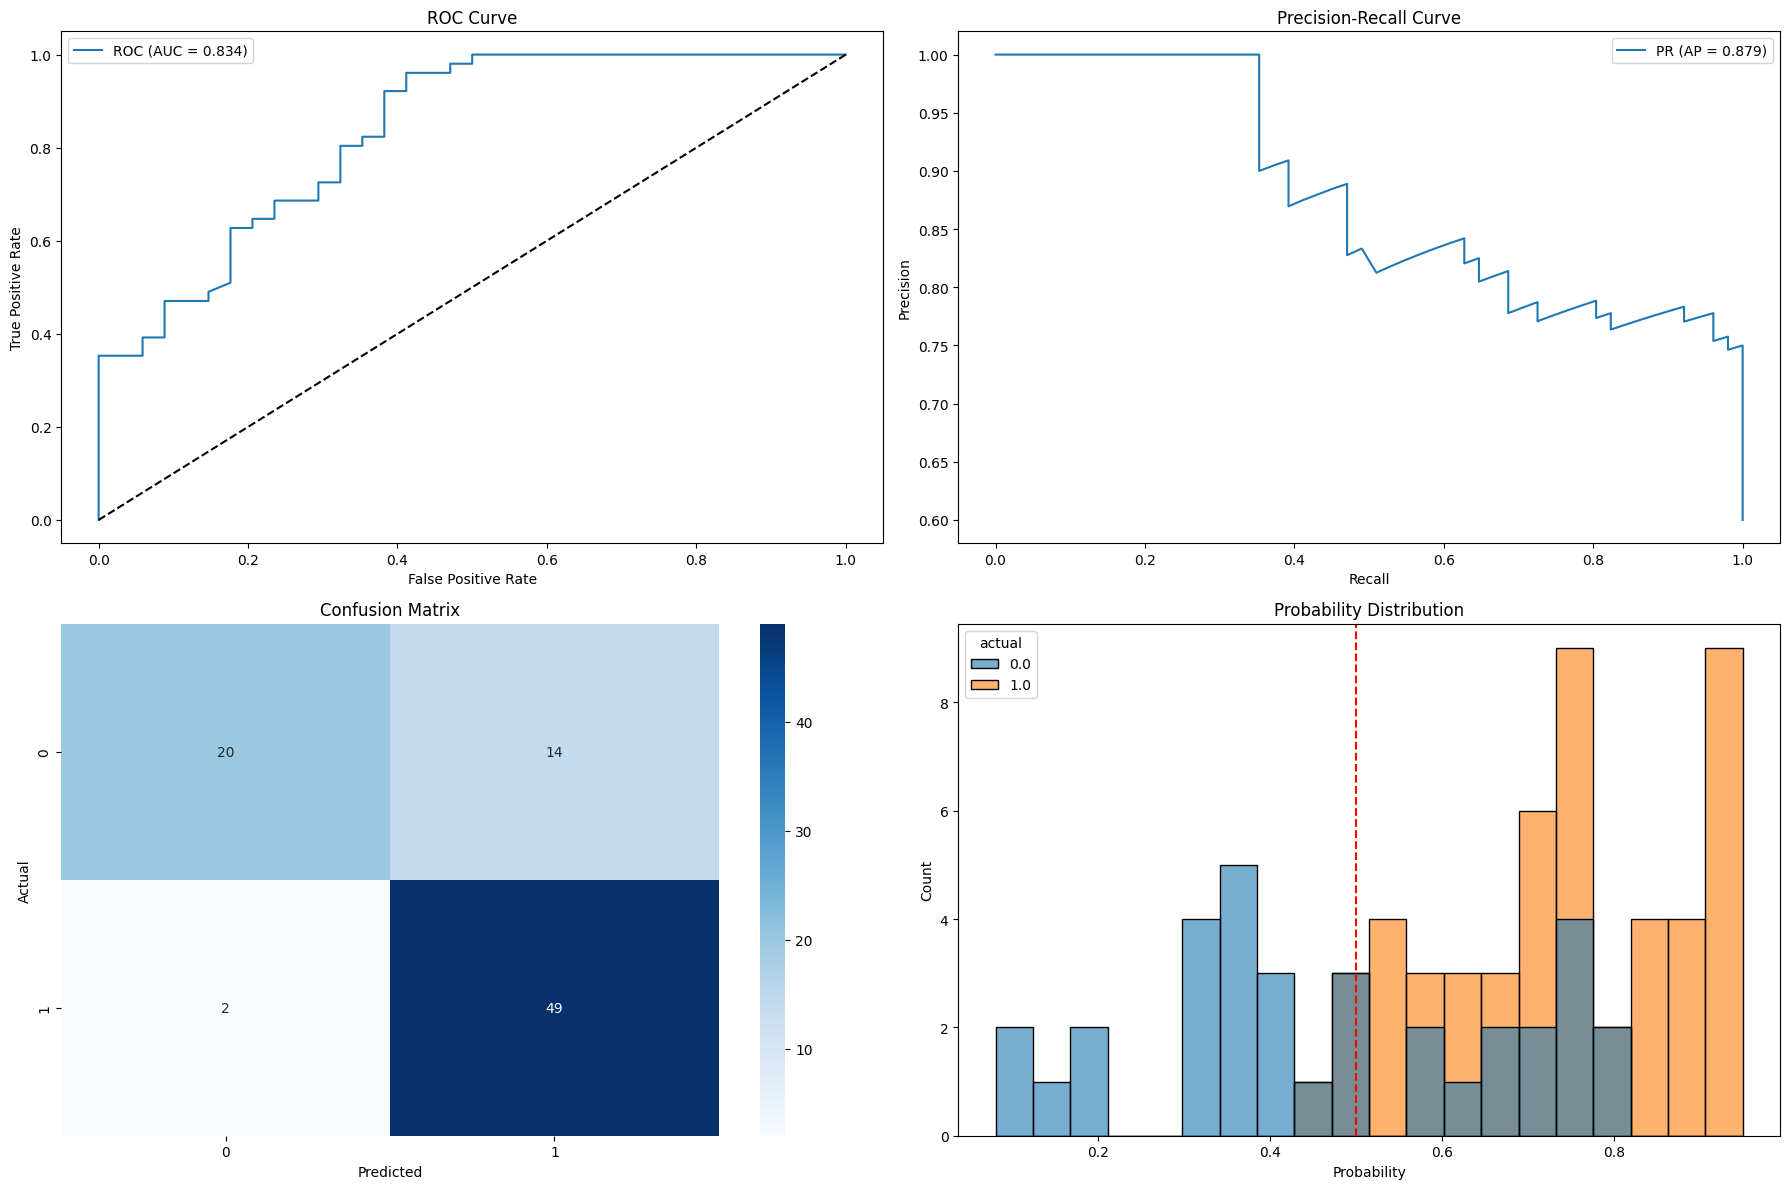


Validation Metrics:
accuracy: 0.8118
precision: 0.7778
recall: 0.9608
f1: 0.8596
roc_auc: 0.8342

Market trend prediction: {'prediction': 'DOWN', 'probability': 0.1739501953125, 'confidence': 0.8260498046875, 'raw_output': -1.5576171875}


In [35]:
# --- Main Execution ---
if __name__ == "__main__":
    try:
        # 1. Prepare data
        df = data  # Assuming 'data' is already loaded into a dataframe
        train_loader, val_loader = prepare_financial_data(df, features)

        # 2. Define hyperparameters using best_params
        best_params = BABA_tunning
        
        lr = best_params['lr']                  # Learning rate
        weight_decay = best_params['weight_decay']  # L2 regularization strength
        dropout = best_params['dropout']        # Dropout probability
        T_0 = best_params['T_0']               # Cosine annealing scheduler warm restart cycle length
        eta_min = best_params['eta_min']       # Minimum learning rate
        patience = best_params['patience']     # Early stopping patience

        # 3. Initialize model (with dropout)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = FinancialTransformer(
            feature_dim=len(features),
            dropout=dropout  
        ).to(device)

        # 4. Train model
        model = train_model(
            model,
            train_loader,
            val_loader,
            epochs=10000,
            lr=lr,
            weight_decay=weight_decay,
            patience=patience,
            T_0=T_0,
            eta_min=eta_min
        )

        # 5. Evaluate
        print("Evaluating on validation set...")
        val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
        plot_results(val_metrics, val_probs, val_targets)

        print("\nValidation Metrics:")
        for k, v in val_metrics.items():
            if k != 'confusion_matrix':
                print(f"{k}: {v:.4f}")

        # 6. Predict
        prediction = predict_future_transformer(df, model, features)
        print(f"\nMarket trend prediction: {prediction}")

    except Exception as e:
        print(f"An error occurred during execution: {e}")
        import traceback
        traceback.print_exc()

## Predict Future Trends

Precision (don’t make false alarms) and recall (don’t miss true signals)

In [36]:
# Usage Example
if __name__ == "__main__":
    # Initialize with trained model
    predictor = MarketPredictor(
        model=model.eval(),  # Fixed the syntax error
        data_df=df,  # Added data_df parameter
        features=features,
        lookback=90
    )
    
    # Generate report
    report = predictor.generate_report(df)
    
    # Print formatted results
    print(f"\nMarket Prediction Report ({report['timestamp']})")
    print(f"Recommendation: {report['recommendation']}")
    print(f"Direction: {report['primary_prediction']['direction']} "
          f"({report['primary_prediction']['confidence_level']} confidence)")
    print(f"Probability: {report['primary_prediction']['probability']:.2%}")
    print(f"\nKey Influential Features:")
    for feat, impact in report['key_features'].items():
        print(f"- {feat}: {impact:.3f}")

Analyzing features: 100%|██████████| 10/10 [00:00<00:00, 16.23it/s]


Market Prediction Report (2025-05-13T10:05:40.723753)
Recommendation: STRONG SELL
Direction: DOWN (VERY HIGH confidence)
Probability: 13.48%

Key Influential Features:
- SlowK: 0.221
- Market_Sentiment_Fearful: 0.139
- UpperBB: 0.114
- Gold: 0.096
- Close: 0.078


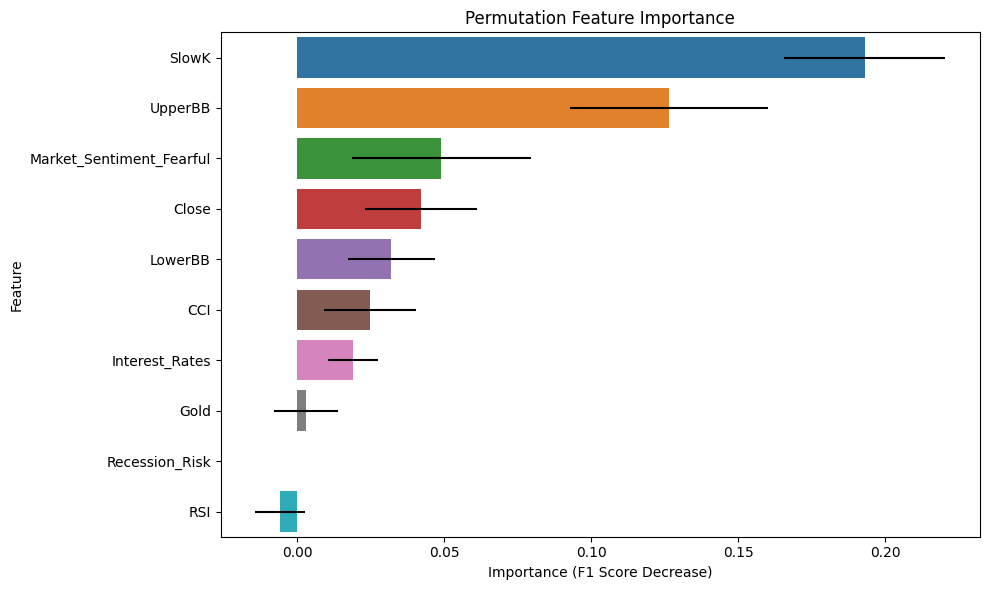

In [37]:
# Calculate permutation importance
perm_importance = calculate_permutation_importance(model, val_loader, features)
plot_feature_importance(perm_importance)

In [38]:
# Save the model's state_dict
torch.save(model.state_dict(), 'financial_transformer_weights.pth')

# Save the entire model
torch.save(model, 'financial_transformer_full.pth')

In [39]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

## Retrain the Model (Weights)

In [40]:
# Define parameters
tickerX = "PDD"
start_date = "2022-01-01"
end_date = "2026-01-01"
window_size = 15

dataX, macro = download_complex_data(tickerX, start_date, end_date)

print(f"\nCombined data shape: {data.shape}")
print(f"Macro data shape: {macro.shape}")

# Generate indicators and trading signals
dataX = generate_trading_signals(dataX)
dataX = encode_macro_features(dataX)

# Drop Null Values
dataX = dataX.dropna()  

[*********************100%***********************]  1 of 1 completed



Combined data shape: (530, 56)
Macro data shape: (590, 38)


/tmp/ipykernel_31/898567495.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('financial_transformer_weights.pth', map_location=device)


✓ Loaded pretrained weights (with architecture mismatch handling)


/tmp/ipykernel_31/1000023226.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.module.load_state_dict(torch.load(best_model_path, map_location=device))


Evaluating on validation set...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

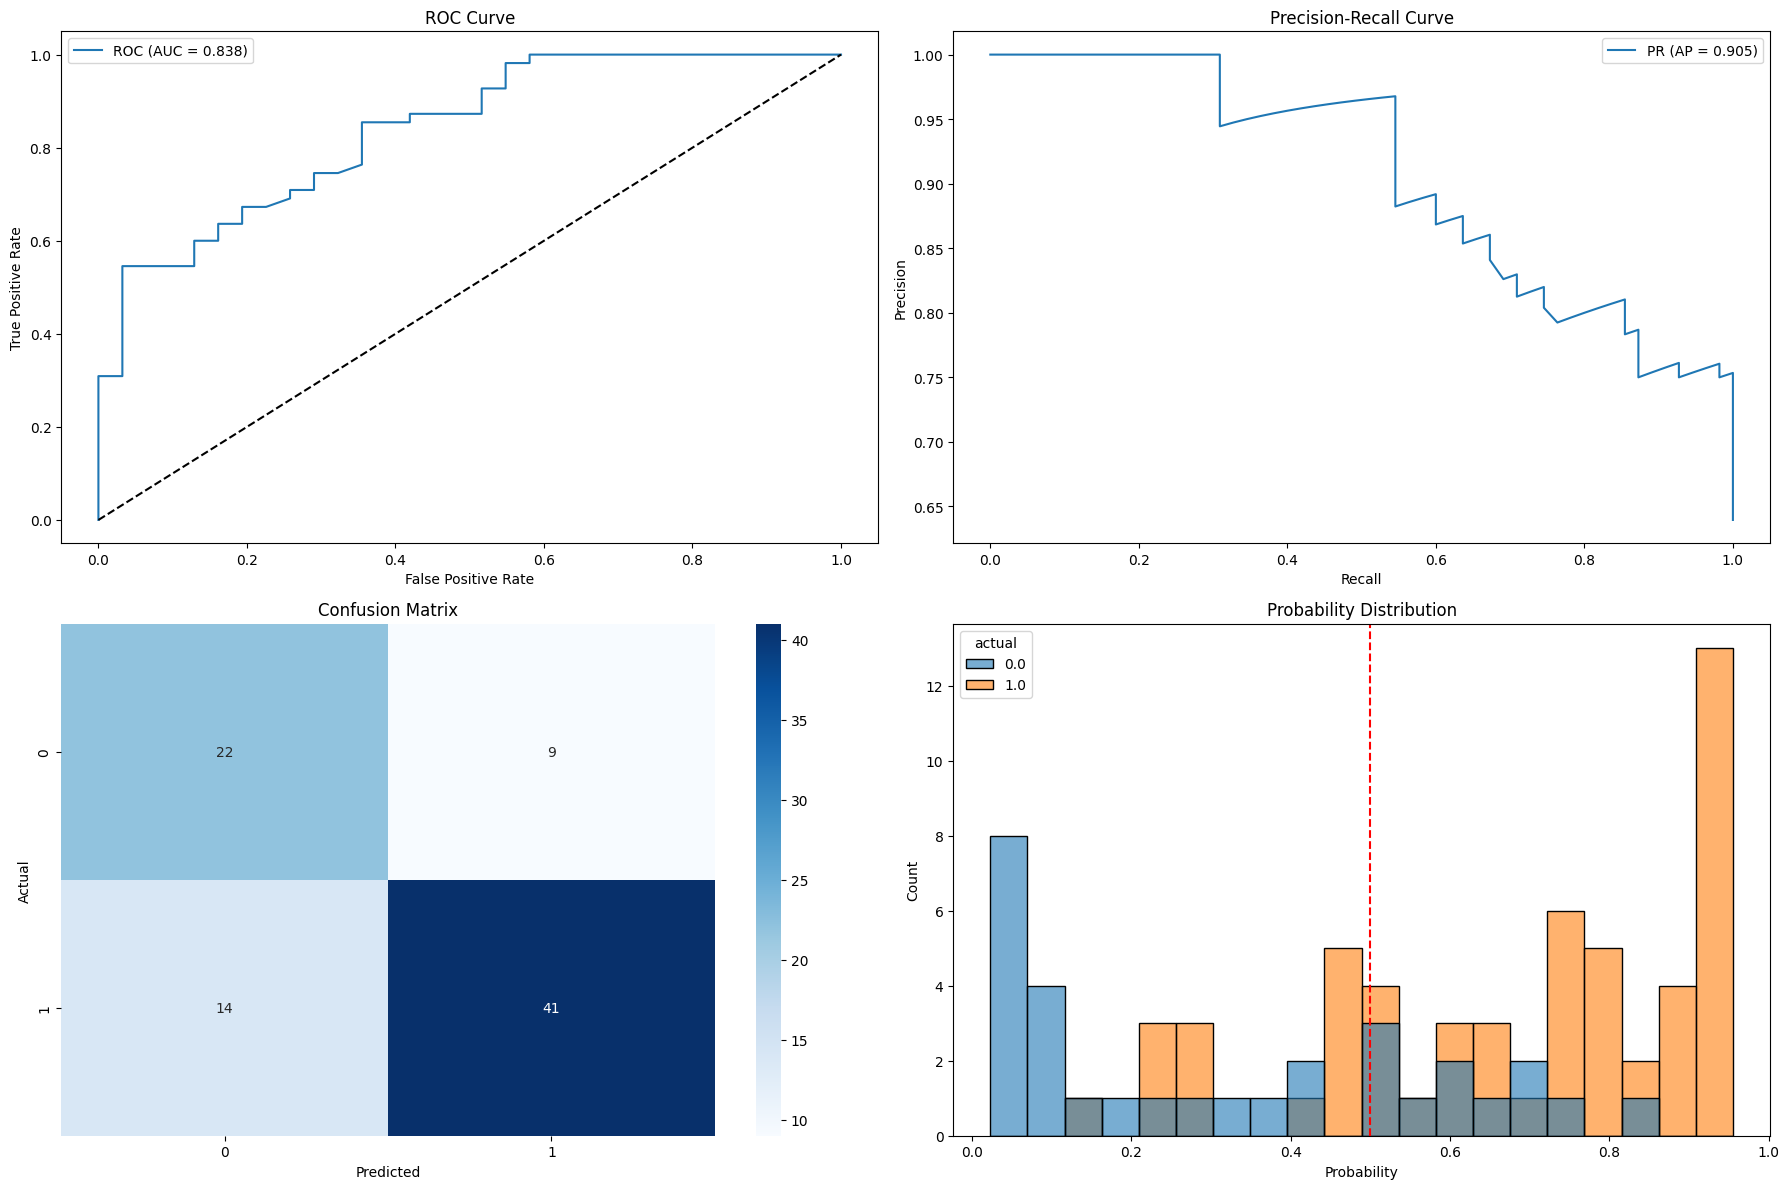


Validation Metrics:
accuracy: 0.7326
precision: 0.8200
recall: 0.7455
f1: 0.7810
roc_auc: 0.8381

Market trend prediction: {'prediction': 'DOWN', 'probability': 0.002620697021484375, 'confidence': 0.9973793029785156, 'raw_output': -5.94140625}


In [41]:
# --- Main Execution ---
if __name__ == "__main__":
    try:
        # 1. Prepare data
        df = dataX  # Use the downloaded and processed data
        train_loader, val_loader = prepare_financial_data(df, features)

        # 2. Define hyperparameters using best_params
        best_params = BABA_tunning
        
        lr = best_params['lr']
        weight_decay = best_params['weight_decay']
        dropout = best_params['dropout']
        T_0 = best_params['T_0']
        eta_min = best_params['eta_min']
        patience = best_params['patience']

        # 3. Initialize model (with dropout)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = FinancialTransformer(
            feature_dim=len(features),
            dropout=dropout  
        ).to(device)

        # Load pretrained weights - FIXED VERSION
        try:
            # Option 1: Recommended approach
            state_dict = torch.load('financial_transformer_weights.pth', map_location=device)
            
            # Handle potential architecture mismatches
            model_state_dict = model.state_dict()
            
            # 1. Filter out unnecessary keys
            pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state_dict}
            
            # 2. Overwrite entries in the existing state dict
            model_state_dict.update(pretrained_dict)
            
            # 3. Load the new state dict
            model.load_state_dict(model_state_dict)
            
            print("✓ Loaded pretrained weights (with architecture mismatch handling)")
            
            # Alternative simple approach (if you're sure about partial loading)
            # model.load_state_dict(state_dict, strict=False)
            
        except FileNotFoundError:
            print("! No pretrained weights found - training from scratch")
        except Exception as e:
            print(f"! Partial weight loading error: {str(e)}")
            # Continue with partial weights

        # 4. Train model
        model = train_model(
            model,
            train_loader,
            val_loader,
            epochs=10000,
            lr=lr,
            weight_decay=weight_decay,
            patience=patience,
            T_0=T_0,
            eta_min=eta_min
        )

        # 5. Evaluate
        print("Evaluating on validation set...")
        val_metrics, val_probs, val_targets = evaluate_model(model, val_loader)
        plot_results(val_metrics, val_probs, val_targets)

        print("\nValidation Metrics:")
        for k, v in val_metrics.items():
            if k != 'confusion_matrix':
                print(f"{k}: {v:.4f}")

        # 6. Predict
        prediction = predict_future_transformer(df, model, features)
        print(f"\nMarket trend prediction: {prediction}")

    except Exception as e:
        print(f"An error occurred during execution: {e}")
        import traceback
        traceback.print_exc()

Analyzing features: 100%|██████████| 10/10 [00:00<00:00, 16.20it/s]



Market Prediction Report (2025-05-13T10:20:52.505084)
Recommendation: STRONG SELL
Direction: DOWN (VERY HIGH confidence)
Probability: 0.27%

Key Influential Features:
- Gold: 0.003
- Market_Sentiment_Fearful: 0.000
- Close: 0.000
- LowerBB: 0.000
- SlowK: 0.000


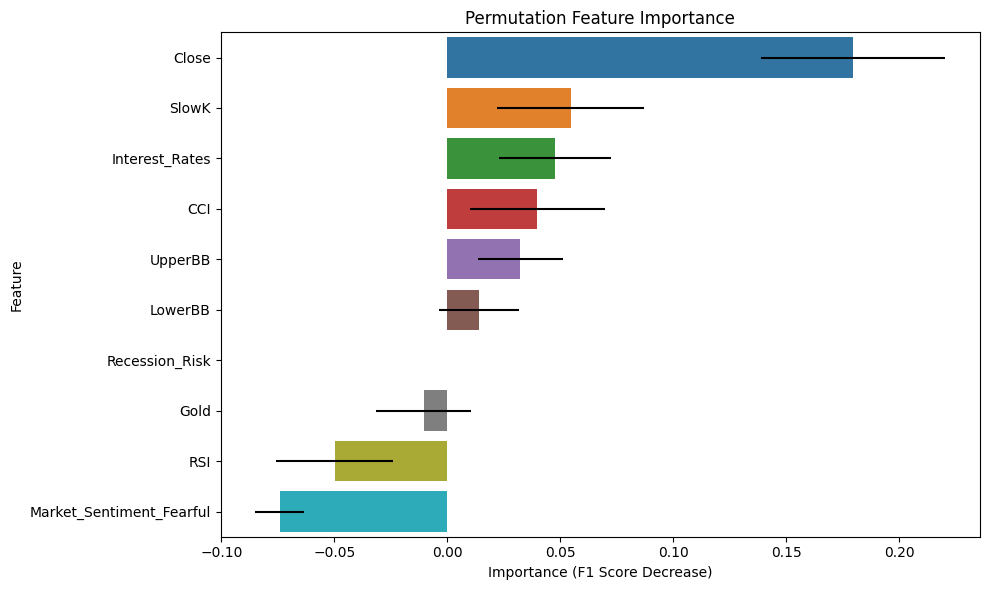

In [42]:
# Usage Example
if __name__ == "__main__":
    # Initialize with trained model
    predictor = MarketPredictor(
        model=model.eval(),  # Fixed the syntax error
        data_df=df,  # Added data_df parameter
        features=features,
        lookback=90
    )
    
    # Generate report
    report = predictor.generate_report(df)
    
    # Print formatted results
    print(f"\nMarket Prediction Report ({report['timestamp']})")
    print(f"Recommendation: {report['recommendation']}")
    print(f"Direction: {report['primary_prediction']['direction']} "
          f"({report['primary_prediction']['confidence_level']} confidence)")
    print(f"Probability: {report['primary_prediction']['probability']:.2%}")
    print(f"\nKey Influential Features:")
    for feat, impact in report['key_features'].items():
        print(f"- {feat}: {impact:.3f}")

    # Calculate permutation importance
    perm_importance = calculate_permutation_importance(model, val_loader, features)
    plot_feature_importance(perm_importance)

## Hyperparameter Tunning


In [43]:
STOP!

SyntaxError: invalid syntax (2635050600.py, line 1)

In [ ]:
if __name__ == "__main__":

    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    # Run only hyperparameter tuning
    best_params = hyperparameter_tuning_only(
        ticker= "KO",
        n_trials= 20,
        use_pretrained= False
    )
    
    if best_params:
        print("\nYou can now use these parameters in your training pipeline:")
        print(best_params)